# Building an Isotropic COSMOS PSF

The aim of this notebook is t

In [1]:
%pylab inline
data_dir='/gpfswork/rech/xdy/uze68md/data/COSMOS_25.2_training_sample'
stamp_size=64
pixel_scale=0.03
k_scale=2. * np.pi / (pixel_scale * stamp_size)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import galsim
# First step is to find an HST PSF that will work for all images,
# we are taking a random sample of 1000 psfs, take the largest one,
# and dilate it a little bit with GalSim
cat = galsim.COSMOSCatalog(dir=data_dir)
psfs = []
psfs_fwhm = []
npsfs = 5000

# Build isotropic PSf
stamp_size=128
pixel_scale=0.03
kscale=2. *  np.pi / (pixel_scale * stamp_size)

ims_r = [ ]

for i in range(npsfs):
    gal = cat.makeGalaxy(i)
    psfs.append(gal.original_psf)
    psfs_fwhm.append(gal.original_psf.calculateFWHM())
    im = gal.original_psf.drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale)
    ims_r.append(abs(im.array))

In [3]:
i_psf_max = np.argmax(array(psfs_fwhm))
psf_max = psfs[i_psf_max]

i_psf_min = np.argmin(array(psfs_fwhm))
psf_min = psfs[i_psf_min]

In [4]:
# Build reference PSF
ref_psf = galsim.InterpolatedKImage(galsim.ImageCD(abs(array(ims_r)).min(axis=0) +0j, scale=kscale))

# Apply transform to make isotropic
ims_r2 = [ ]
for i in range(360):
    im = ref_psf.rotate(galsim.Angle(i*np.pi/180., galsim.radians)).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale)
    ims_r2.append(abs(im.array))

mat = abs(array(ims_r2)).min(axis=0)
mat = mat + mat.T
effective_psf = galsim.InterpolatedKImage(galsim.ImageCD(mat+0j, scale=kscale))
# Apply some dilation and normalize the PSF
#effective_psf = effective_psf.dilate(1.01).withFlux(1.)

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


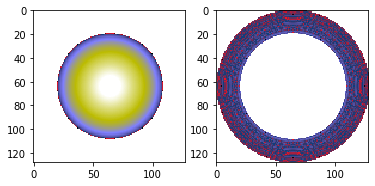

In [5]:
# Truncating psf to remove the zeros at the edges
mask = log10(mat/mat.max()) > -4.5 
subplot(121)
imshow(log10(mat*mask)  ,cmap='gist_stern',vmax=0); #colorbar()
subplot(122)
imshow(log10(mat*(1-mask))  ,cmap='gist_stern',vmax=0); #colorbar()

In [6]:
# Cropping the PSF image
coords = np.argwhere(mask)
x_min, y_min = coords.min(axis=0)
x_max, y_max = coords.max(axis=0)
cropped = (mask*mat)[x_min:x_max+1, y_min:y_max+1]

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


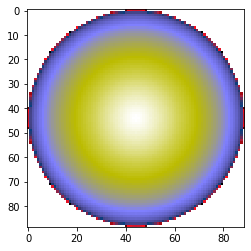

In [7]:
imshow(log10(cropped),cmap='gist_stern'); #colorbar()

In [8]:
nyquist_scale = effective_psf.nyquist_scale
dilation_ratio = 0.168/nyquist_scale

In [9]:
effective_psf = galsim.InterpolatedKImage(galsim.ImageCD(cropped+0j, scale=kscale))
from astropy.io import fits
# Exporting the effective PSF
im = effective_psf.drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale) # HST pixel scale
fits.writeto('./hst_cosmos_effective_psf.fits', np.abs(im.array), clobber=True)

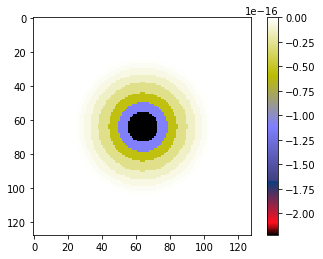

In [10]:
# LOAD and check PSF

psf_cfht = galsim.InterpolatedKImage(galsim.ImageCD(fits.getdata('./hst_cosmos_effective_psf.fits'),scale=kscale))

imshow((np.abs(psf_cfht.drawKImage(nx=stamp_size,ny=stamp_size).array)-np.abs(im.array)),cmap='gist_stern');plt.colorbar();





Populating the interactive namespace from numpy and matplotlib


/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


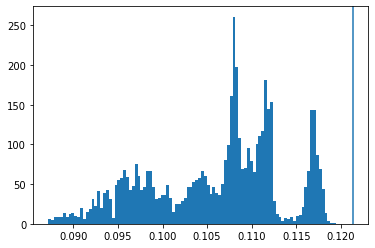

In [11]:
%pylab inline
hist(array(psfs_fwhm),100);
axvline(effective_psf.calculateFWHM())

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


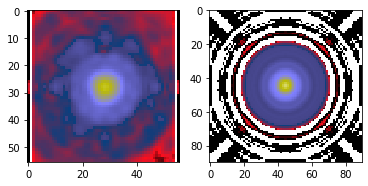

In [12]:
subplot(121)
imshow(log10(psf_max.drawImage().array),cmap='gist_stern',vmin=-6,vmax=0); 
subplot(122)
imshow(log10(effective_psf.drawImage().array),cmap='gist_stern',vmin=-6,vmax=0);

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 1.0, 'non isotropic avg psf')

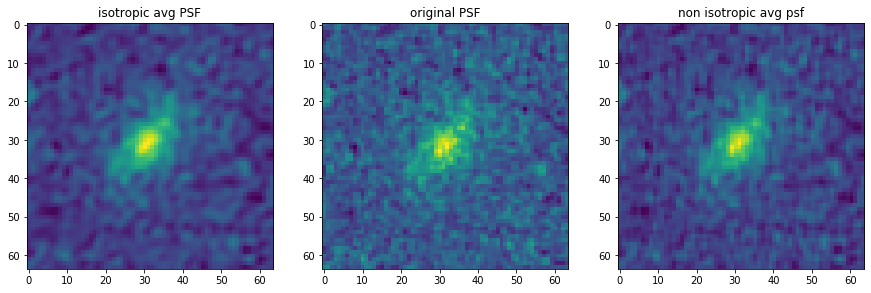

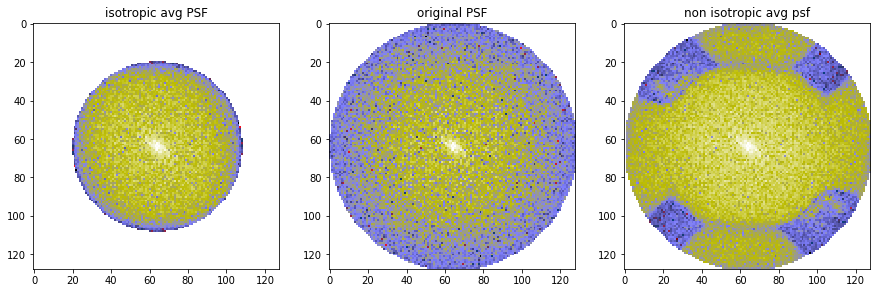

In [13]:
figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(131)
galsim.Convolve(gal, effective_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('isotropic avg PSF')
subplot(132)
galsim.Convolve(gal, gal.original_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('original PSF')
subplot(133)
galsim.Convolve(gal, ref_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('non isotropic avg psf')

figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(131)
imshow(log10(abs(galsim.Convolve(gal, effective_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('isotropic avg PSF')
subplot(132)
imshow(log10(abs(galsim.Convolve(gal, gal.original_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('original PSF')
subplot(133)
imshow(log10(abs(galsim.Convolve(gal, ref_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('non isotropic avg psf')

## Gaussian PSF

In Florent's paper the target PSF was a 2D Gaussian of FWHM=0.07" 

In [14]:
psf_gauss_hip = galsim.Gaussian(flux=1., sigma=0.07) # PSF flux should always = 1
psf_gauss_flo = galsim.Gaussian(flux=1., fwhm=0.07) # PSF flux should always = 1

## Euclid PSF

The PSF used for Euclid is generated using the function of Galsim to simulate optical PSF with realistic parameters corresponding to Euclid's specifications.

In [15]:
lam = 700  # nm
diam = 1.3    # meters
lam_over_diam = (lam * 1.e-9) / diam  # radians
lam_over_diam *= 206265  # Convert to arcsec
exp_time = 2260# exposure time
euclid_eff_area = 1.15 #effective area
psf_euclid = galsim.OpticalPSF(lam=lam, diam=diam, scale_unit=galsim.arcsec)

# rename the COSMOS PSF
psf_cosmos = effective_psf

## CFHT PSF

The PSF used for CFHT is generated using the Kolmogorov model of Galsim to simulate resulting PSF made of the telescope PSF and the atmospherical PSF.

In [16]:
import sys
cfht_dir = '/gpfswork/rech/xdy/uze68md/GitHub/ShapeDeconv/data/CFHT'
sys.path.append(cfht_dir)
from seeing_distribution_class import seeing_distribution

seed = 1995
fwhm_sampler = seeing_distribution(cfht_dir+'/seeing_distribution.npy',seed=seed)
cfht_fwhm = fwhm_sampler.get(1)[0]
psf_cfht = galsim.Kolmogorov(fwhm=cfht_fwhm,flux=1.0, scale_unit=galsim.arcsec)
# shear the PSF
g_sigma = 0.01 # standard deviation of the shear distribution
def get_g(n_g):
    g = np.random.normal(0., g_sigma, n_g)
    while np.linalg.norm(g) > 1:
        g = np.random.normal(0., g_sigma, n_g)
    return g
np.random.seed(seed=seed)
e1, e2 = get_g(2) #+[cst1, cst2] because the mean of the PSF ellipticity can be different from zero
psf_cfht = psf_cfht.shear(g1=e1, g2=e2)

## Compare PSF

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 1.0, 'Gaussian Hippolyte PSF')

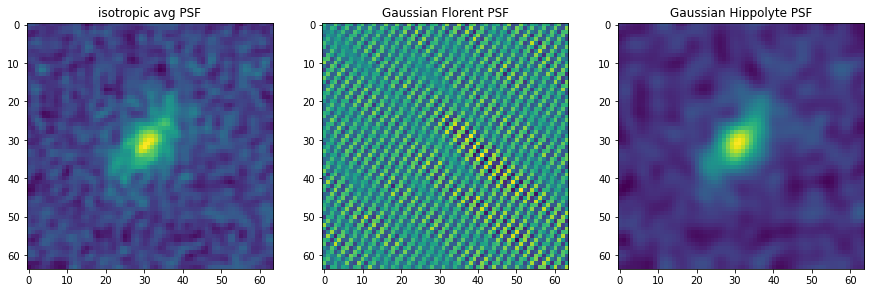

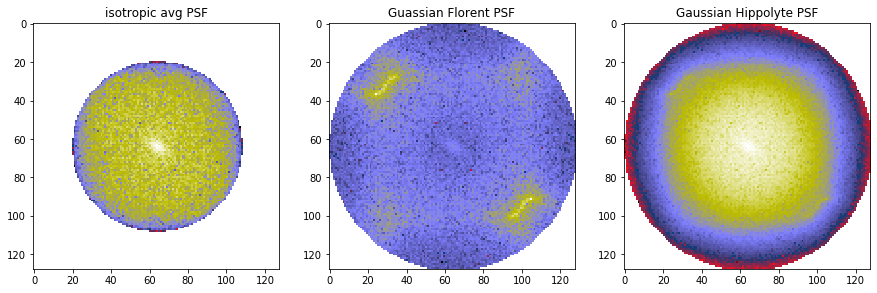

In [17]:
figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(131)
galsim.Convolve(gal, effective_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('isotropic avg PSF')
subplot(132)
galsim.Convolve(gal, psf_gauss_flo).drawImage(im, method='no_pixel');
imshow(im.array)
title('Gaussian Florent PSF')
subplot(133)
galsim.Convolve(gal, psf_gauss_hip).drawImage(im, method='no_pixel');
imshow(im.array)
title('Gaussian Hippolyte PSF')

figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(131)
imshow(log10(abs(galsim.Convolve(gal, effective_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('isotropic avg PSF')
subplot(132)
imshow(log10(abs(galsim.Convolve(gal, psf_gauss_flo).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Guassian Florent PSF')
subplot(133)
imshow(log10(abs(galsim.Convolve(gal, psf_gauss_hip).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Gaussian Hippolyte PSF')

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 1.0, 'Gaussian Hippolye PSF')

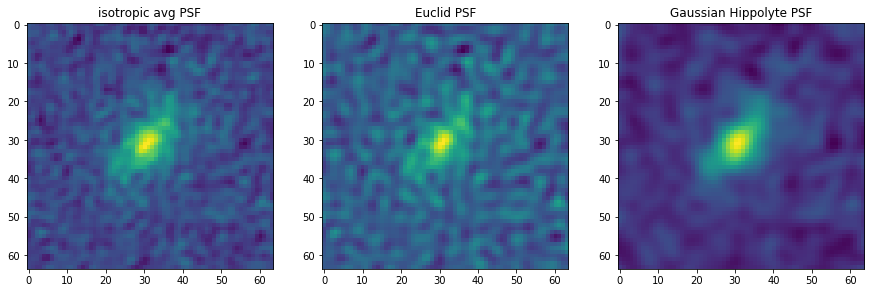

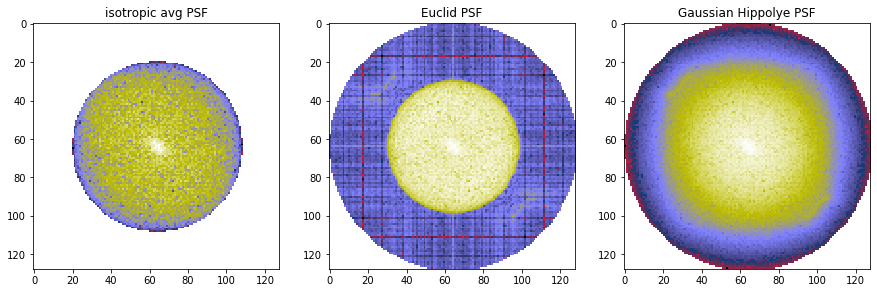

In [18]:
figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(131)
galsim.Convolve(gal, effective_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('isotropic avg PSF')
subplot(132)
galsim.Convolve(gal, psf_euclid).drawImage(im, method='no_pixel');
imshow(im.array)
title('Euclid PSF')
subplot(133)
galsim.Convolve(gal, psf_gauss_hip).drawImage(im, method='no_pixel');
imshow(im.array)
title('Gaussian Hippolyte PSF')

figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(131)
imshow(log10(abs(galsim.Convolve(gal, effective_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('isotropic avg PSF')
subplot(132)
imshow(log10(abs(galsim.Convolve(gal, psf_euclid).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Euclid PSF')
subplot(133)
imshow(log10(abs(galsim.Convolve(gal, psf_gauss_hip).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Gaussian Hippolye PSF')

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 1.0, 'Gaussian Hippolye PSF')

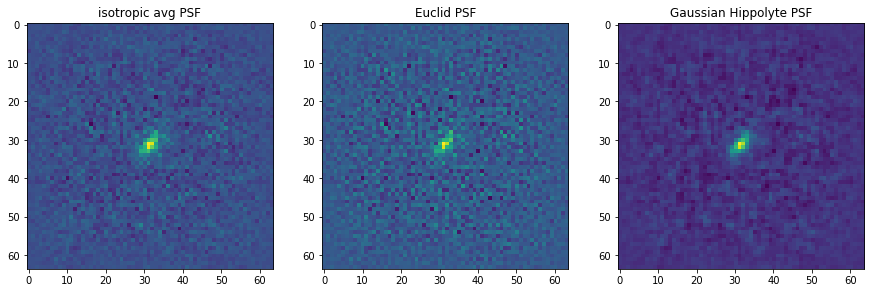

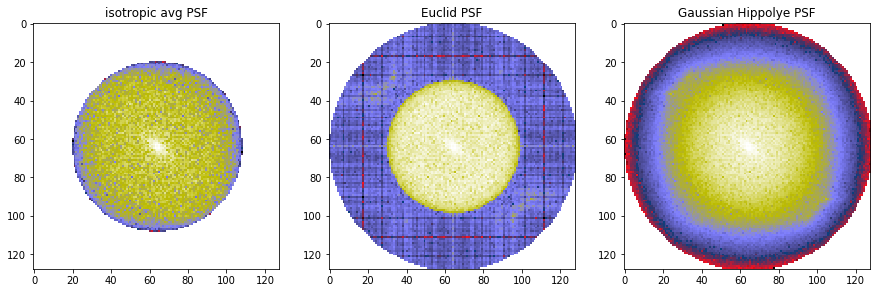

In [19]:
figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.1)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(131)
galsim.Convolve(gal, effective_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('isotropic avg PSF')
subplot(132)
galsim.Convolve(gal, psf_euclid).drawImage(im, method='no_pixel');
imshow(im.array)
title('Euclid PSF')
subplot(133)
galsim.Convolve(gal, psf_gauss_hip).drawImage(im, method='no_pixel');
imshow(im.array)
title('Gaussian Hippolyte PSF')

figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(131)
imshow(log10(abs(galsim.Convolve(gal, effective_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('isotropic avg PSF')
subplot(132)
imshow(log10(abs(galsim.Convolve(gal, psf_euclid).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Euclid PSF')
subplot(133)
imshow(log10(abs(galsim.Convolve(gal, psf_gauss_hip).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Gaussian Hippolye PSF')

## Euclid vs CFHT

Comparison using Euclid pixel scale.

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 1.0, 'CFHT PSF')

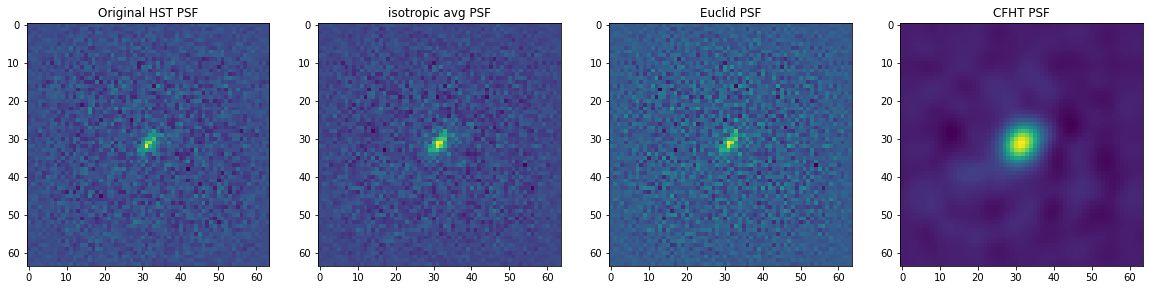

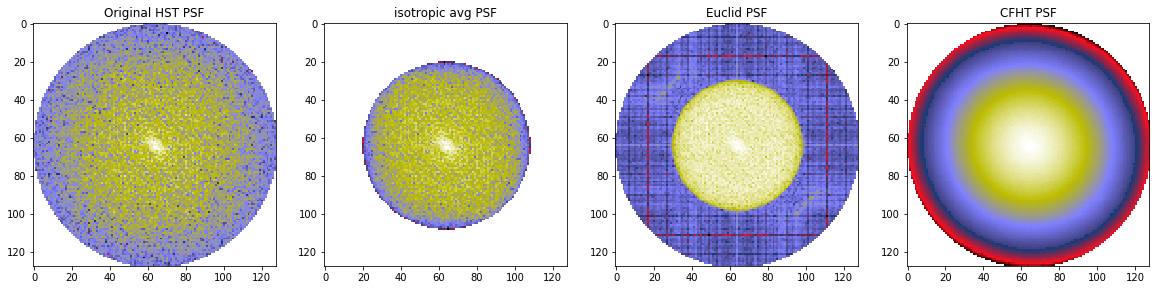

In [20]:
figure(figsize=(20,5))
im = galsim.Image(64,64, scale=0.101) # Euclid pixel scale
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(141)
galsim.Convolve(gal, gal.original_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('Original HST PSF')
subplot(142)
galsim.Convolve(gal, effective_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('isotropic avg PSF')
subplot(143)
galsim.Convolve(gal, psf_euclid).drawImage(im, method='no_pixel');
imshow(im.array)
title('Euclid PSF')
subplot(144)
galsim.Convolve(gal, psf_cfht).drawImage(im, method='no_pixel');
imshow(im.array)
title('CFHT PSF')

figure(figsize=(20,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(141)
imshow(log10(abs(galsim.Convolve(gal, gal.original_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Original HST PSF')
subplot(142)
imshow(log10(abs(galsim.Convolve(gal, effective_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('isotropic avg PSF')
subplot(143)
imshow(log10(abs(galsim.Convolve(gal, psf_euclid).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Euclid PSF')
subplot(144)
imshow(log10(abs(galsim.Convolve(gal, psf_cfht).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('CFHT PSF')

Comparison using CFHT pixel scale.

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 1.0, 'CFHT PSF')

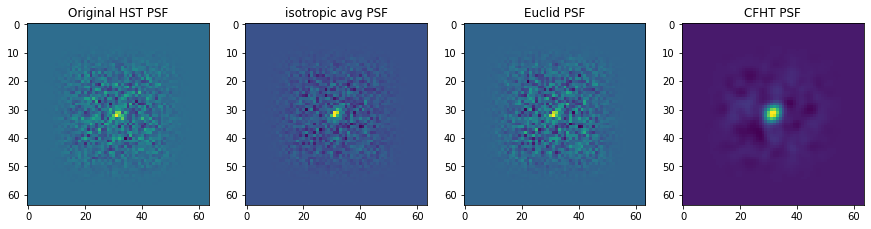

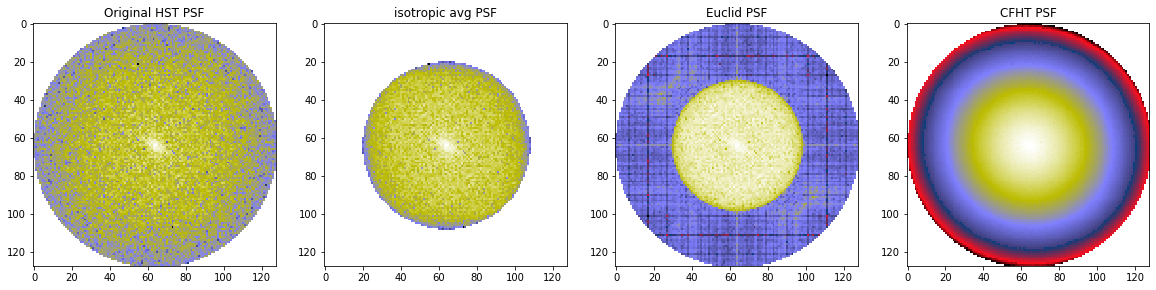

In [21]:
figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.185) # CFHT pixel scale
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(141)
galsim.Convolve(gal, gal.original_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('Original HST PSF')
subplot(142)
galsim.Convolve(gal, effective_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('isotropic avg PSF')
subplot(143)
galsim.Convolve(gal, psf_euclid).drawImage(im, method='no_pixel');
imshow(im.array)
title('Euclid PSF')
subplot(144)
galsim.Convolve(gal, psf_cfht).drawImage(im, method='no_pixel');
imshow(im.array)
title('CFHT PSF')

figure(figsize=(20,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(141)
imshow(log10(abs(galsim.Convolve(gal, gal.original_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Original HST PSF')
subplot(142)
imshow(log10(abs(galsim.Convolve(gal, effective_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('isotropic avg PSF')
subplot(143)
imshow(log10(abs(galsim.Convolve(gal, psf_euclid).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Euclid PSF')
subplot(144)
imshow(log10(abs(galsim.Convolve(gal, psf_cfht).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('CFHT PSF')

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 1.0, 'CFHT PSF')

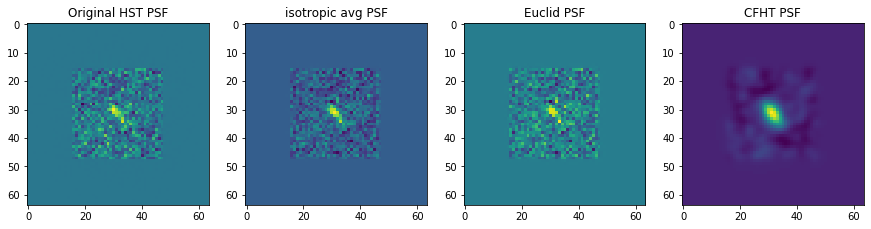

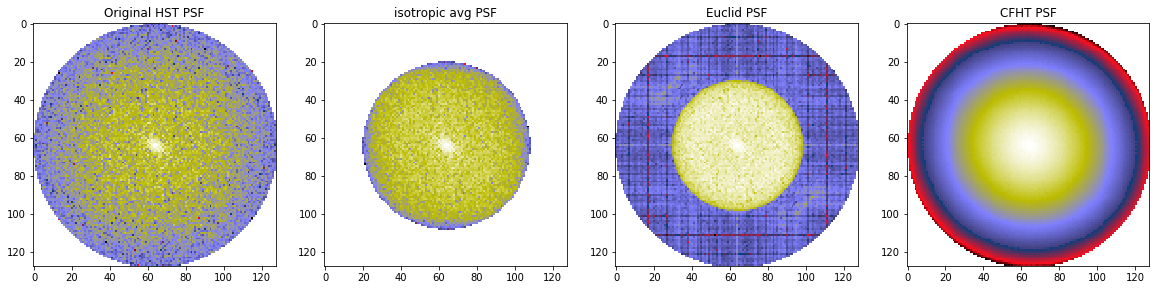

In [22]:
figure(figsize=(15,5))
im = galsim.Image(64,64, scale=0.185) # CFHT pixel scale
gal  = cat.makeGalaxy(45, noise_pad_size=2*64 * 0.03)
subplot(141)
galsim.Convolve(gal, gal.original_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('Original HST PSF')
subplot(142)
galsim.Convolve(gal, effective_psf).drawImage(im, method='no_pixel');
imshow(im.array)
title('isotropic avg PSF')
subplot(143)
galsim.Convolve(gal, psf_euclid).drawImage(im, method='no_pixel');
imshow(im.array)
title('Euclid PSF')
subplot(144)
galsim.Convolve(gal, psf_cfht).drawImage(im, method='no_pixel');
imshow(im.array)
title('CFHT PSF')

figure(figsize=(20,5))
im = galsim.Image(64,64, scale=0.03)
gal  = cat.makeGalaxy(12, noise_pad_size=2*64 * 0.03)
gal2 = cat.makeGalaxy(123, noise_pad_size=2*64 * 0.03)
subplot(141)
imshow(log10(abs(galsim.Convolve(gal, gal.original_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Original HST PSF')
subplot(142)
imshow(log10(abs(galsim.Convolve(gal, effective_psf).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('isotropic avg PSF')
subplot(143)
imshow(log10(abs(galsim.Convolve(gal, psf_euclid).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('Euclid PSF')
subplot(144)
imshow(log10(abs(galsim.Convolve(gal, psf_cfht).drawKImage(nx=stamp_size,ny=stamp_size, scale=kscale).array)), cmap='gist_stern')
title('CFHT PSF')